<a href="https://colab.research.google.com/github/nithin-seenivasan/Document-Tracking-Tool/blob/main/FinalProject_GOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialize Environment**

In [ ]:
!git clone https://github.com/nithin-seenivasan/twitter-analysis

import os
os.chdir("twitter-analysis")

Cloning into 'twitter-analysis'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 69 (delta 2), reused 6 (delta 1), pack-reused 61
Unpacking objects: 100% (69/69), done.
Checking out files: 100% (21/21), done.


Add the config.py file here, if the API key is required. It's not on Github, since I don't want to expose API key there. 

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 58 kB 2.4 MB/s 
     |████████████████████████████████| 4.0 MB 8.6 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.6 MB 38.8 MB/s 
     |████████████████████████████████| 42 kB 812 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8 MB 16.1 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
     |████████████████████████████████| 77 kB 3.6 MB/s 
     |████████████████████████████████| 880 kB 48.7 MB/s 
     |████████████████████████████████| 1.1 MB 38.1 MB/s 
     |████████████████████████████████| 162 kB 44.9 MB/s 
     |████████████████████████████████| 181 kB 44.7 MB/s 
     |████████████████████████████████| 144 kB 66.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import umap
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import scripts.TextAnalysis as ta
from scripts.api import *


from datetime import datetime, timedelta
import sqlite3, sys, os
from collections import Counter
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import codecs  #this let's us display tweets properly (emojis, etc.)

pd.set_option("display.max_colwidth", None)


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/iolib/foreign.py:633: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

# Load Tweets 

Note: We first downloaded 26k tweets for the keywords "Ghost of Kiev" and "GhostofKiev". We then later realized we were excluding a LARGE part of the dataset by not including "Kyiv", which is the newer way to write the city's name. Adding "Ghost of Kyiv" and "GhostofKyiv", we got 78.9k tweets. 

In [ ]:
fname_db = "data/gok_all_22feb_14apr"  #Updated GOK file - has ALL tweets

df = DB.fetch(table_name='keyword_tweets', path=fname_db)

In [ ]:
len(df)

78590

In [ ]:
df.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2022-04-13T23:36:30.000Z,None,"this is wilder than any of the ""ghost of kiev"" stuff. if you had told someone on february 24 that almost two months into the war the Ukrainians were threatening to sink Russia's flagship in the black sea you would have sounded completely insane lol",en,12,4,89,0,1514387079790215174,349817494,1514386669335687169,349817494,nan,"{'annotations': [{'start': 8, 'end': 13, 'probability': 0.5983, 'type': 'Person', 'normalized_text': 'wilder'}, {'start': 169, 'end': 174, 'probability': 0.9889, 'type': 'Place', 'normalized_text': 'Russia'}]}"
1,2022-04-13T23:35:34.000Z,None,"@The_key_master @IntelDoge lol they even sent a bunch of shit about the ""ghost of kiev"" out from their official channels\n\nthere's no shame in running disinfo but they definitely do it",en,0,1,0,0,1514386846750588938,1466131806940508161,1514381282754637832,45566060,nan,"{'mentions': [{'start': 0, 'end': 15, 'username': 'The_key_master', 'id': '45566060'}, {'start': 16, 'end': 26, 'username': 'IntelDoge', 'id': '2407993940'}]}"


In [ ]:
df.tail(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
78588,2022-02-24T19:57:26.000Z,None,"#ghostofkyiv the based guy of Ukraine air force, and your mig-29 vs the Russian air force, please, you are a hero. And the su-27 on Romania, you be can a hero too.",en,3,1,20,0,1496937332150259717,1255196551753990144,1496937332150259717,nan,nan,"{'hashtags': [{'start': 0, 'end': 12, 'tag': 'ghostofkyiv'}], 'annotations': [{'start': 30, 'end': 36, 'probability': 0.9419, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 132, 'end': 138, 'probability': 0.9537, 'type': 'Place', 'normalized_text': 'Romania'}]}"
78589,2022-02-24T19:41:28.000Z,None,@Sc0ttishKoala #ghostofkyiv keep the skies clear,en,4,0,35,0,1496933313335857168,1262316790593531905,1496904999456370690,898524398486929408,nan,"{'mentions': [{'start': 0, 'end': 14, 'username': 'Sc0ttishKoala', 'id': '898524398486929408'}], 'hashtags': [{'start': 15, 'end': 27, 'tag': 'ghostofkyiv'}]}"


#Nithin - Fundamental Analysis

##### Add Created at Datetime column (to sort by)

In [ ]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

format = "%Y-%m-%d %H:%M:%S"
df_keyword ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword ['tweet_indicator'] = np.ones(len(df_keyword ))
df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7

78590 keyword tweets


In [ ]:
from google.colab import files

df_keyword.to_csv('gok_unprocessed.csv', encoding = 'utf-8-sig') 
files.download('gok_unprocessed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#####Time Series Plot (rate of new tweets)

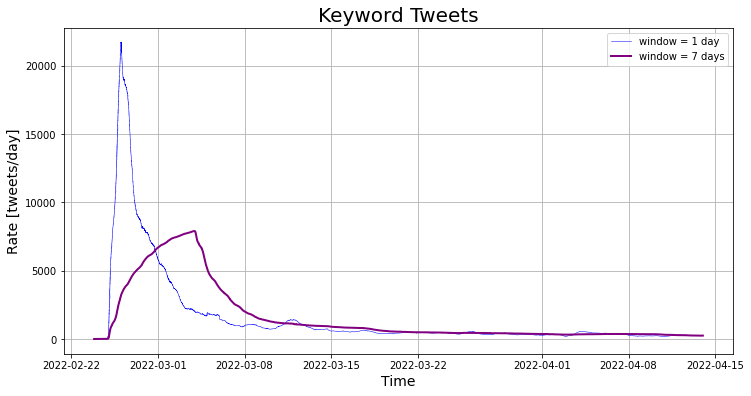

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

Insight: Trend peaked around 28 Feb 2022, and started to fall immediately and dramatically after that. This was around the time news outlets started publishing articles debunking the claims. 

#####Sort by Date - what were the first 25 tweets?

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['created_at_datetime'], ascending = True).head(n=25)

,created_at_datetime,text,like_count,retweet_count
23990,2022-02-23 20:38:41,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",0,0
23989,2022-02-24 03:20:16,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",3,0
70109,2022-02-24 03:20:16,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",3,0
23988,2022-02-24 07:51:18,"Should I call out of work tomorrow???\n""Sorry, kids. Couldn't come to class last time bc Russia's attacking Kiev half a world away and I'm very antsy about it for reasons that are beyond your understanding rn. But anyways, let's keep writing our Ghost Chicken Nuggets adventure.""",6,0
23987,2022-02-24 10:15:40,"@daisyelfling This will be a fait acompli over in a few days, all land east of the Dniper will be occupied and Kiev a ghost town on the border",0,0
23986,2022-02-24 12:15:40,Ghost of kiev https://t.co/DAMmmYxFxB,2,0
23985,2022-02-24 13:04:48,"@JobeerBa PARAPHRASING: THE EMPTY BRAVADO OF UKRAINE , AND BEHIND THEM is the cowardly SHOE BIDEN, &amp; its western flank with an EMPTY MURMUR, IT IS NOW CLEAR WITH THIS SCENE of THE CAPITAL KIEV #كييف HAS BECOME A GHOST TOWN PREPARING TO RECEIVE PUTIN'S SOLDIERS",1,0
23984,2022-02-24 13:36:26,Television pictures of ghost town Kiev blaring air raid sirens is absolutely frightening. It's not a false alarm !,1,0
70108,2022-02-24 15:30:22,It’s wild how quickly kyiv became a ghost town in a matter of hours on snap map,0,0
23983,2022-02-24 16:01:38,"@soluTium1 @GobHenMLDL @SexymhieQ @AJAYRIAH66 @UnitedPatriot22 @WongLi2515 @EyeEres @FhqJackie @ligaya2021 @AltNiSam1 @MissyLizah78 @ACCTV4 @spartacusfilip @Grumpy_YO @raincyrainy @GrowlHarhar @gwapoarawaraw @LoVe_MeOw_24 @itsmeLJHeart @LheysanpI @maine_worldwide @TalaZaldivar @ABCancaloo @DolorNolet @MDSOnwardPH22 @iamshoberamos @NileSneel @choy_kapitan @archerqueen2 @Jjcruz2 @2021_raine @rolem03_chick @ApatheticDame @Battousai0522 @Proudly__pinay @IHateFakePple @GoldDaMalditass @Ms_Trizzia_ @LilMsMalditaMD @wonderbingboom @CarpeDiem_IAm @glaced2perfexn @gracia_licious @bplorienne1 @grazzeem @KimIndar @YesYesYo13 @ZayWhaat @pads_nosi Kiev, Ukraine capital is a ghost town.. residents are scrambling and fleeing the city.. long line of vehicles going out of the city..\n\nChernobyl nuclear plant is now a target of Russian attack..\n\nUkraine offers weapons to anyone who wants to fight..",8,1


**Insight**: First tweet with major engagemet was on 2022-02-24 17:59:26	, with 484 likes. There were a couple of tweets about it before, but the accounts have been since deleted (SUSPICIOUS!)

#####Sort the tweets by like count. 

  Print out the screen name, text, and like count of the top five tweets in descending order (only print these three columns).

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count','author_id']].sort_values(by = ['like_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count,author_id
69691,2022-02-25 00:39:45,"There is reportedly a Ukrainian fighter pilot who has taken out 6 Russian jets in air to air combat. He is being called the ""Ghost of Kyiv""\nhttps://t.co/zCdK2URsHM",167158,22655,817007725666242561
69791,2022-02-25 00:28:40,"They calling this nigga ghost of kyiv, this the hardest Shit I’ve ever heard in my life. https://t.co/p4S57UxJIM",128039,17064,1691569358
66892,2022-02-25 03:35:58,Ghost of Kyiv is the coldest nickname I’ve ever heard,97146,6384,292508851
46847,2022-02-27 07:22:37,"People call him the Ghost of Kyiv. And rightly so — this UAF ace dominates the skies over our capital and country, and has already become a nightmare for invading Russian aircrafts. https://t.co/lngfaMN01I",80683,13134,732521058507620356
69951,2022-02-24 23:52:22,Rumors from the Ukraine frontline allege a “Ghost of Kyiv” has downed 6 Russian jets.” via MilitaryAircraft. https://t.co/HTuQ62EhJS,71922,8478,48173196
69972,2022-02-24 23:32:49,Reports of this lone pilot having shot down 6 Russian Aircraft and possibly being the first 21st century Ace are circulating. They're being nicknamed the Ghost of Kyiv and I am in fucking awe. https://t.co/lakzodkEiU,50298,5630,3293504896
69489,2022-02-25 00:57:06,Ghost of Kyiv emerging as an early hero in the fight for Ukraine. https://t.co/KzYSOYOI4o,45600,5491,618786340
69541,2022-02-25 00:52:04,"I’m begging major media to report on whether “The Ghost of Kyiv” really exists—as if it’s true that today a heroic Ukrainian fighter pilot single-handedly downed *6* Russian jets, this flying ace immediately becomes a stirring symbol of Ukraine’s resistance to Putin’s war crimes. https://t.co/Nmlu68Fknj",40143,6654,3223426134
64711,2022-02-25 08:01:40,"Throughout the conflict in Ukraine seen today, there is one Ukrainian MiG-29 Fighter Jet that is soaring through the skies of Kyiv, this single fighter jet has already earned itself an alias, the 'Ghost of Kyiv', and has already downed SIX Russian aircraft. https://t.co/onMFnZBD7r",36332,4794,470915474
41685,2022-02-28 18:09:33,⚡️The legendary Ghost of #Kyiv has already shot down 14 occupier planes. https://t.co/vwfYwJUthB,35478,4054,1891490382


Insight: ((See SMA Project Plan for the data supporting the following insights):

1.   Most liked tweet was from 2022-02-25 00:39:45 (167158 likes, 22655k retweets) from an account called @MarketRebels (Bio:We're on a mission to empower retail traders with the tools they need to succeed.)
2.   Range of dates where most engagement was generated was between 24 and 28 Feb 
3.   Total engagement from top 10 tweets: 752,799 likes, 94,388 retweets
4.   For just GhostOfKiev and Ghost of Kiev - There is a mix of memes (2 tweets), tweets suggesting it is "cool" despite being fake (1 tweet), tweets calling out fake news (1 tweet) MIXED with the fake news (6 tweets)
5. For just GhostOfKyiv and Ghost of Kyiv - Almost all tweets extol the greatness of this fictional pilot, and these are reaching a LOT of people






#####Sort the tweets by Retweet count. 

Print out the screen name, text, and Retweet count of the top five tweets in descending order (only print these three columns).

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['retweet_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count
69691,2022-02-25 00:39:45,"There is reportedly a Ukrainian fighter pilot who has taken out 6 Russian jets in air to air combat. He is being called the ""Ghost of Kyiv""\nhttps://t.co/zCdK2URsHM",167158,22655
69791,2022-02-25 00:28:40,"They calling this nigga ghost of kyiv, this the hardest Shit I’ve ever heard in my life. https://t.co/p4S57UxJIM",128039,17064
46847,2022-02-27 07:22:37,"People call him the Ghost of Kyiv. And rightly so — this UAF ace dominates the skies over our capital and country, and has already become a nightmare for invading Russian aircrafts. https://t.co/lngfaMN01I",80683,13134
69951,2022-02-24 23:52:22,Rumors from the Ukraine frontline allege a “Ghost of Kyiv” has downed 6 Russian jets.” via MilitaryAircraft. https://t.co/HTuQ62EhJS,71922,8478
69541,2022-02-25 00:52:04,"I’m begging major media to report on whether “The Ghost of Kyiv” really exists—as if it’s true that today a heroic Ukrainian fighter pilot single-handedly downed *6* Russian jets, this flying ace immediately becomes a stirring symbol of Ukraine’s resistance to Putin’s war crimes. https://t.co/Nmlu68Fknj",40143,6654
68917,2022-02-25 01:33:11,"BREAKING: Unconfirmed rumors are spreading about ""The Ghost of Kyiv,"" a Ukrainian fighter pilot who is believed to have shot down at least 6 Russian planes, a feat which would make him a ""Flying Ace,"" a legend amongst pilots. RT IF YOU SUPPORT UKRAINIAN FIGHTER PILOTS!",23976,6406
66892,2022-02-25 03:35:58,Ghost of Kyiv is the coldest nickname I’ve ever heard,97146,6384
69972,2022-02-24 23:32:49,Reports of this lone pilot having shot down 6 Russian Aircraft and possibly being the first 21st century Ace are circulating. They're being nicknamed the Ghost of Kyiv and I am in fucking awe. https://t.co/lakzodkEiU,50298,5630
69489,2022-02-25 00:57:06,Ghost of Kyiv emerging as an early hero in the fight for Ukraine. https://t.co/KzYSOYOI4o,45600,5491
64711,2022-02-25 08:01:40,"Throughout the conflict in Ukraine seen today, there is one Ukrainian MiG-29 Fighter Jet that is soaring through the skies of Kyiv, this single fighter jet has already earned itself an alias, the 'Ghost of Kyiv', and has already downed SIX Russian aircraft. https://t.co/onMFnZBD7r",36332,4794


Insight: Sorting by retweet_count also gets similar insights as with likes. Key point to note is that the top liked and retweeted tweet (that is not calling out Fake news) is from 2022-02-25 00:39:45

#####Create Wordcloud of entire dataset

In [ ]:
stopwords = set(STOPWORDS)##

df = DB.fetch(table_name= 'keyword_tweets', path = fname_db) #fetch the table named "user_tweets" at path fname_db to dataframe called "df"
#df = df[['screen_name', 'text']] #remove all columns except these two (overwrite function)
df['text_clean'] = df.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df = df[df.text_clean.str.len() > 0]

n = len(df)
print(f"There are {n} tweets in the dataframe")
df.sample(n=5)


There are 78590 tweets in the dataframe


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,text_clean
77198,2022-02-25T07:21:27.000Z,None,"People are saying the #ghostofkyiv is propaganda, but I don't think it is. #Russia is scared and don't want to seem weak. Keep fighting #Ukraine people and always know you are not alone. #FuckPutin #PrayingForUkraine https://t.co/sMEAN7j2TN",en,0,0,1,0,1497109469809066008,864886782,1497109469809066008,nan,nan,"{'hashtags': [{'start': 22, 'end': 34, 'tag': 'ghostofkyiv'}, {'start': 75, 'end': 82, 'tag': 'Russia'}, {'start': 136, 'end': 144, 'tag': 'Ukraine'}, {'start': 187, 'end': 197, 'tag': 'FuckPutin'}, {'start': 198, 'end': 216, 'tag': 'PrayingForUkraine'}], 'urls': [{'start': 217, 'end': 240, 'url': 'https://t.co/sMEAN7j2TN', 'expanded_url': 'https://twitter.com/PalmPrimus/status/1497109469809066008/photo/1', 'display_url': 'pic.twitter.com/sMEAN7j2TN'}]}",people are saying the ghostofkyiv is propaganda but i dont think it is russia is scared and dont want to seem weak keep fighting ukraine people and always know you are not alone fuckputin prayingforukraine
66613,2022-02-25T03:52:53.000Z,None,@rocketsszn13 @spectatorindex Tbh this ghost of kyiv is made-up,en,0,1,8,0,1497056985090596869,1226214199866658816,1497056560774000643,1250184764994334720,nan,"{'annotations': [{'start': 48, 'end': 51, 'probability': 0.7112, 'type': 'Place', 'normalized_text': 'kyiv'}], 'mentions': [{'start': 0, 'end': 13, 'username': 'rocketsszn13', 'id': '1250184764994334720'}, {'start': 14, 'end': 29, 'username': 'spectatorindex', 'id': '1626294277'}]}",rocketsszn13 spectatorindex tbh this ghost of kyiv is madeup
33505,2022-03-08T08:41:15.000Z,None,ghost of kyiv jokes getting very stale,en,0,0,0,0,1501115819341881345,1403013463488745478,1501115819341881345,nan,nan,nan,ghost of kyiv jokes getting very stale
70577,2022-03-11T20:54:26.000Z,None,What if the #ghostofkyiv was actually #TheStig ?,en,0,0,0,0,1502387496675651597,2849796161,1502387496675651597,nan,nan,"{'hashtags': [{'start': 12, 'end': 24, 'tag': 'ghostofkyiv'}, {'start': 38, 'end': 46, 'tag': 'TheStig'}]}",what if the ghostofkyiv was actually thestig
34970,2022-03-05T16:11:36.000Z,None,"the CBC engaging holocaust revisionism to defend Bandarists, and CTV rattling on about the heroism of the ""ghost of kyiv"" and journalists seeing russian conspiracies behind everything and Charlie Angus wants us to believe we need to be on guard against ""russian"" propaganda",en,0,0,1,0,1500141990964613124,1479627742933135368,1500141990964613124,nan,nan,"{'annotations': [{'start': 49, 'end': 58, 'probability': 0.3472, 'type': 'Person', 'normalized_text': 'Bandarists'}, {'start': 188, 'end': 200, 'probability': 0.9928, 'type': 'Person', 'normalized_text': 'Charlie Angus'}]}",the cbc engaging holocaust revisionism to defend bandarists and ctv rattling on about the heroism of the ghost of kyiv and journalists seeing russian conspiracies behind everything and charlie angus wants us to believe we need to be on guard against russian propaganda


In [ ]:
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")
stopwords.add("Ghostofkyiv")
stopwords.add("Kyiv")

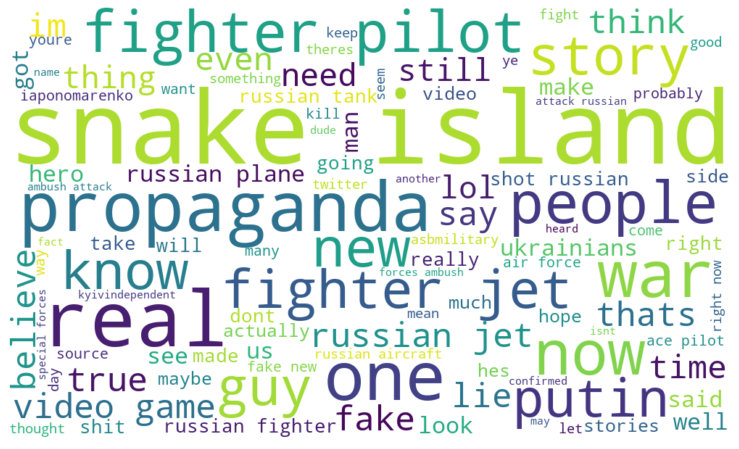

In [ ]:
text=' '.join(df.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insight: Kinda cool that GoK wordcloud shows Snake Island as a major trend

#Nithin - Sentiment Analysis of Entire Dataset

#####Initialization of Model 

Already ran this, took 4 hours. Don't run this again, import from the CSV file that I exported. See next section for the code. 

In [ ]:
df['created_at_datetime'] = pd.to_datetime(df['created_at'],format=format).dt.tz_localize(None)

In [ ]:
len(df)

78590

Snip the bottom 6.5k tweets, since Colab broke off runtime after processing 75000 tweets (costing me 3 hours..)

In [ ]:
df1=df.sort_values(by = 'created_at_datetime', ascending = True).head(72000)

In [ ]:
len(df1)

72000

In [ ]:
df=df1

In [ ]:
len(df)

72000

Confirm the top and bottom of the dataframe

In [ ]:
df.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime
23990,2022-02-23T20:38:41.000Z,None,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",en,0,1,0,0,1496585327204470784,40311253,1496578659670499330,407020992,nan,"{'mentions': [{'start': 0, 'end': 8, 'username': 'varbmos', 'id': '407020992'}, {'start': 9, 'end': 19, 'username': 'peterdaou', 'id': '18464266'}], 'annotations': [{'start': 26, 'end': 28, 'probability': 0.8232, 'type': 'Other', 'normalized_text': 'God'}, {'start': 42, 'end': 51, 'probability': 0.4109, 'type': 'Person', 'normalized_text': 'Russiagate'}, {'start': 212, 'end': 215, 'probability': 0.931, 'type': 'Place', 'normalized_text': 'Kiev'}]}",2022-02-23 20:38:41
23989,2022-02-24T03:20:16.000Z,None,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",en,0,1,3,0,1496686387541778432,2823778745,1496686387541778432,nan,nan,"{'urls': [{'start': 81, 'end': 104, 'url': 'https://t.co/66v0XT1QeW', 'expanded_url': 'https://webcam.guru.ua/city/Kiev/', 'display_url': 'webcam.guru.ua/city/Kiev/'}, {'start': 105, 'end': 128, 'url': 'https://t.co/VV6MqUTsjN', 'expanded_url': 'https://twitter.com/stormsellwx/status/1496686387541778432/video/1', 'display_url': 'pic.twitter.com/VV6MqUTsjN'}], 'annotations': [{'start': 15, 'end': 18, 'probability': 0.9841, 'type': 'Place', 'normalized_text': 'Kyiv'}, {'start': 21, 'end': 27, 'probability': 0.4673, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 63, 'end': 69, 'probability': 0.9769, 'type': 'Place', 'normalized_text': 'Ukraine'}]}",2022-02-24 03:20:16


In [ ]:
df.tail(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime
3724,2022-03-24T23:12:25.000Z,None,"Ok twitter, supposed fast news source, are you not mentioning that Ukraine supposedly blew up a Russian ship for a reason?\nOr is this another in endless series of BS propaganda (ghost of Kiev style)\n\nhttps://t.co/xOwrAVpjx0",en,0,0,0,0,1507133261901967361,950569548654067712,1507133261901967361,nan,nan,"{'annotations': [{'start': 3, 'end': 9, 'probability': 0.4131, 'type': 'Organization', 'normalized_text': 'twitter'}, {'start': 67, 'end': 73, 'probability': 0.9688, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 187, 'end': 190, 'probability': 0.4622, 'type': 'Place', 'normalized_text': 'Kiev'}], 'urls': [{'start': 200, 'end': 223, 'url': 'https://t.co/xOwrAVpjx0', 'expanded_url': 'https://www.msn.com/en-gb/news/world/ukraine-says-it-has-destroyed-a-large-russian-landing-ship/ar-AAVrOot', 'display_url': 'msn.com/en-gb/news/wor…'}]}",2022-03-24 23:12:25
3723,2022-03-24T23:20:55.000Z,None,@GeromanAT It was the Ghost of Kiev 🤣😂😱✈️,en,0,0,1,0,1507135399507943431,1496918982946865159,1507134802016804865,3373146857,nan,"{'annotations': [{'start': 22, 'end': 37, 'probability': 0.2392, 'type': 'Other', 'normalized_text': 'Ghost of Kiev 🤣'}], 'mentions': [{'start': 0, 'end': 10, 'username': 'GeromanAT', 'id': '3373146857'}]}",2022-03-24 23:20:55


Download Sentiment model from Huggingface

In [ ]:
%%time
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

CPU times: user 14.4 s, sys: 4.1 s, total: 18.5 s
Wall time: 31.3 s


In [ ]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    
    return sentiment

In [ ]:
%%time
c = 0
Sentiment = []
for index,row in df.iterrows():  #iterate over rows of dataframe
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df)}")  #print progres every 1000 rows

    sentiment = sentiment_classifier(row.text,model,tokenizer)  #calculate sentiment and embedding of tweet
    Sentiment.append(sentiment)  #append sentiment of tweet to Sentiment list

df['sentiment'] = Sentiment  #add sentiment column to dataframe of tweets
df.head()

Tweet 1000/72000
Tweet 2000/72000
Tweet 3000/72000
Tweet 4000/72000
Tweet 5000/72000
Tweet 6000/72000
Tweet 7000/72000
Tweet 8000/72000
Tweet 9000/72000
Tweet 10000/72000
Tweet 11000/72000
Tweet 12000/72000
Tweet 13000/72000
Tweet 14000/72000
Tweet 15000/72000
Tweet 16000/72000
Tweet 17000/72000
Tweet 18000/72000
Tweet 19000/72000
Tweet 20000/72000
Tweet 21000/72000
Tweet 22000/72000
Tweet 23000/72000
Tweet 24000/72000
Tweet 25000/72000
Tweet 26000/72000
Tweet 27000/72000
Tweet 28000/72000
Tweet 29000/72000
Tweet 30000/72000
Tweet 31000/72000
Tweet 32000/72000
Tweet 33000/72000
Tweet 34000/72000
Tweet 35000/72000
Tweet 36000/72000
Tweet 37000/72000
Tweet 38000/72000
Tweet 39000/72000
Tweet 40000/72000
Tweet 41000/72000
Tweet 42000/72000
Tweet 43000/72000
Tweet 44000/72000
Tweet 45000/72000
Tweet 46000/72000
Tweet 47000/72000
Tweet 48000/72000
Tweet 49000/72000
Tweet 50000/72000
Tweet 51000/72000
Tweet 52000/72000
Tweet 53000/72000
Tweet 54000/72000
Tweet 55000/72000
Tweet 56000/72000
T

Insight: Haha.. 4 hours!! 

###### Import exported CSV file of results

I exported this dataframe as a CSV file. So would never have to run it again. Import DF with this from CSV

In [ ]:
from google.colab import files

df.to_csv('gok_processed.csv', encoding = 'utf-8-sig') 
files.download('gok_processed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv('data/gok_processed.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.head(2)

,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,sentiment,star
0,23990,2022-02-23T20:38:41.000Z,None,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",en,0.0,1.0,0.0,0.0,1.496585e+18,4.031125e+07,1496578659670499330,407020992.0,NaN,"{'mentions': [{'start': 0, 'end': 8, 'username': 'varbmos', 'id': '407020992'}, {'start': 9, 'end': 19, 'username': 'peterdaou', 'id': '18464266'}], 'annotations': [{'start': 26, 'end': 28, 'probability': 0.8232, 'type': 'Other', 'normalized_text': 'God'}, {'start': 42, 'end': 51, 'probability': 0.4109, 'type': 'Person', 'normalized_text': 'Russiagate'}, {'start': 212, 'end': 215, 'probability': 0.931, 'type': 'Place', 'normalized_text': 'Kiev'}]}",2022-02-23 20:38:41,1.585668,2.0
1,23989,2022-02-24T03:20:16.000Z,None,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",en,0.0,1.0,3.0,0.0,1.496686e+18,2.823779e+09,1496686387541778432,NaN,NaN,"{'urls': [{'start': 81, 'end': 104, 'url': 'https://t.co/66v0XT1QeW', 'expanded_url': 'https://webcam.guru.ua/city/Kiev/', 'display_url': 'webcam.guru.ua/city/Kiev/'}, {'start': 105, 'end': 128, 'url': 'https://t.co/VV6MqUTsjN', 'expanded_url': 'https://twitter.com/stormsellwx/status/1496686387541778432/video/1', 'display_url': 'pic.twitter.com/VV6MqUTsjN'}], 'annotations': [{'start': 15, 'end': 18, 'probability': 0.9841, 'type': 'Place', 'normalized_text': 'Kyiv'}, {'start': 21, 'end': 27, 'probability': 0.4673, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 63, 'end': 69, 'probability': 0.9769, 'type': 'Place', 'normalized_text': 'Ukraine'}]}",2022-02-24 03:20:16,4.232207,4.0


#####Mean sentiment of all tweets

Insight: Average sentiment seems to be in the middle, suggesting that negative and positive extremes are being balanced out (plus the possibility of a sizeable tweet population in the middle) - next step will confirm/reject this hypothesis. 

#####Sentiment Distribution of entire Dataset

In [ ]:
mean_opinion = df['sentiment'].mean()
print(f"Mean opinion of the tweets:{mean_opinion}")

Mean opinion of the tweets:2.7717962981544457


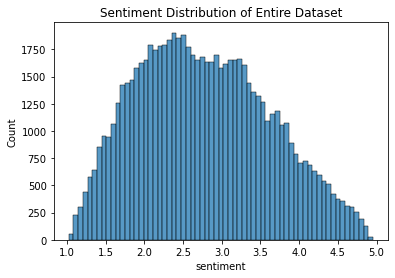

In [ ]:
  df_plot = df
  sns.histplot(data=df_plot, x = "sentiment")
  plt.title(f"Sentiment Distribution of Entire Dataset")
  plt.show()

Insight: Lots of negative words such as "killed", "war", "soldiers" pull the sentiments down. Most tweets cluster around the 2-2.5 range. 

In [ ]:
df['star']=df.sentiment.round(0)

In [ ]:
df.sample(3)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,sentiment,star
53278,2022-02-26T04:01:13.000Z,None,"Pilot who shot down six enemy planes, he was nicknamed \n""The Ghost of Kiev"". Big honour.\n Hero of Ukraine.#Ghost of Kyiv #UkraineInvasion #Ukrainian #worldwar3 #UkraineRussia\nhttps://t.co/70wFihwM2h https://t.co/mYnuNEqLsg",en,2,1,10,0,1497421470359691264,1270760036214677506,1497421470359691264,nan,nan,"{'hashtags': [{'start': 106, 'end': 112, 'tag': 'Ghost'}, {'start': 121, 'end': 137, 'tag': 'UkraineInvasion'}, {'start': 138, 'end': 148, 'tag': 'Ukrainian'}, {'start': 149, 'end': 159, 'tag': 'worldwar3'}, {'start': 160, 'end': 174, 'tag': 'UkraineRussia'}], 'annotations': [{'start': 70, 'end': 73, 'probability': 0.3588, 'type': 'Place', 'normalized_text': 'Kiev'}, {'start': 98, 'end': 104, 'probability': 0.971, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 116, 'end': 119, 'probability': 0.86, 'type': 'Place', 'normalized_text': 'Kyiv'}], 'urls': [{'start': 199, 'end': 222, 'url': 'https://t.co/mYnuNEqLsg', 'expanded_url': 'https://twitter.com/yashpatel13_/status/1497421470359691264/photo/1', 'display_url': 'pic.twitter.com/mYnuNEqLsg'}, {'start': 175, 'end': 198, 'url': 'https://t.co/70wFihwM2h', 'expanded_url': 'https://twitter.com/donmwatu/status/1497279671683194885/photo/1', 'display_url': 'pic.twitter.com/70wFihwM2h'}]}",2022-02-26 04:01:13,3.904941,4.0
34939,2022-03-05T17:03:15.000Z,None,#PinoyAviatorsLIFE\n\nTHE “GHOST OF KYIV” LIVES ON IN THE HEARTS OF ALL WHO FIGHT TO DEFEND UKRAINE \nR.I.P. \n\nhttps://t.co/Bjtt6oavHN,en,0,0,0,0,1500154986663186433,2645236572,1500154986663186433,nan,nan,"{'hashtags': [{'start': 0, 'end': 18, 'tag': 'PinoyAviatorsLIFE'}], 'urls': [{'start': 108, 'end': 131, 'url': 'https://t.co/Bjtt6oavHN', 'expanded_url': 'https://youtu.be/7YaXdP06zO0', 'display_url': 'youtu.be/7YaXdP06zO0'}], 'annotations': [{'start': 34, 'end': 37, 'probability': 0.518, 'type': 'Place', 'normalized_text': 'KYIV'}, {'start': 90, 'end': 96, 'probability': 0.8993, 'type': 'Place', 'normalized_text': 'UKRAINE'}]}",2022-03-05 17:03:15,4.083047,4.0
9689,2022-03-06T09:54:49.000Z,None,"@jd_durkin She refuted nothing. just heresay. there was never a ghost of kiev, and almost everyting coming out is propaganda. The ukranians are dying by the thousands and here we are sitting and clapping for thier demise. its disgusting and we should stop.",en,0,0,0,0,1500409558782517248,1495630463632744448,1498116325222371329,45511031,nan,"{'mentions': [{'start': 0, 'end': 10, 'username': 'jd_durkin', 'id': '45511031'}], 'annotations': [{'start': 73, 'end': 76, 'probability': 0.4848, 'type': 'Place', 'normalized_text': 'kiev'}]}",2022-03-06 09:54:49,1.168578,1.0


##### Retweet count vs Sentiment 

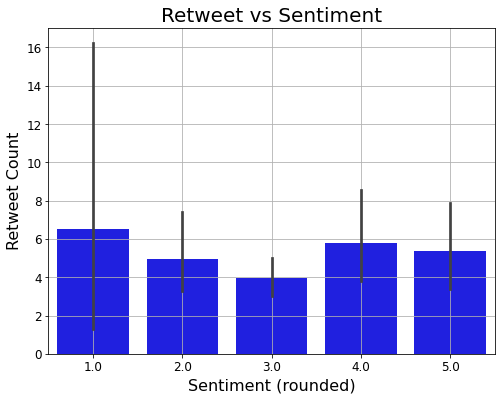

In [ ]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'retweet_count', x = 'star', color = "blue")
plt.xlabel('Sentiment (rounded)', fontsize = 16)
plt.ylabel('Retweet Count', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Retweet vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

Insight: Lowest sentiment tweets look like they are retweeted more, but the error band is large, indicating not a very reliable result. The higher sentiment tweets are retweeted more than the 3* rated tweets  (neutral tweets aren't as popular as the extremes) 

##### T-Test for Sentiment 1.0

Since 1.0 has such a wide error band, we do a statistic analysis to check for whether it is statistically significant

Null hypothesis: Mean retweet count is statistically similar between the two groups 

If pVal <= alpha - Reject null hypothesis. I.e the difference is statistically significant at 1% levels. 

If pVal > alpha - Accept null hypothesis. I.e the difference is not statistically significant at 1% levels. 

In [32]:
w1 = 1
w2 = [2, 3,4,5]

for w2 in w2:
  X0 = df.retweet_count[df.star==w1]
  X1 = df.retweet_count[df.star==w2]
  mu0 = np.mean(X0)
  mu1 = np.mean(X1)
  (tstat, pval) =stats.ttest_ind(X0,X1, equal_var = False)

  print(f"Star\tMean retweet count")
  print(f"{w1}\t{mu0:.2f}")
  print(f"{w2}\t{mu1:.2f}")
  print(f"Comparing Retweet Counts for {w1} vs {w2}: t-stat = {tstat:.3f} ({pval:.4f})\n")
  alpha = 0.01  #significance level
  if pval <=alpha:
    print(f"Significant at {alpha*100}% level")
  else:
    print(f"Not significant at {alpha*100}% level. Mean retweet count of both groups within statistical tolerance of {alpha*100}% ")
  print("\n------------------------------------------\n")

Star	Mean retweet count
1	6.51
2	4.96
Comparing Retweet Counts for 1 vs 2: t-stat = 0.340 (0.7338)

Not significant at 1.0% level. Mean retweet count of both groups within statistical tolerance of 1.0% 

------------------------------------------

Star	Mean retweet count
1	6.51
3	3.94
Comparing Retweet Counts for 1 vs 3: t-stat = 0.574 (0.5658)

Not significant at 1.0% level. Mean retweet count of both groups within statistical tolerance of 1.0% 

------------------------------------------

Star	Mean retweet count
1	6.51
4	5.80
Comparing Retweet Counts for 1 vs 4: t-stat = 0.155 (0.8772)

Not significant at 1.0% level. Mean retweet count of both groups within statistical tolerance of 1.0% 

------------------------------------------

Star	Mean retweet count
1	6.51
5	5.39
Comparing Retweet Counts for 1 vs 5: t-stat = 0.243 (0.8082)

Not significant at 1.0% level. Mean retweet count of both groups within statistical tolerance of 1.0% 

------------------------------------------



##### Top 5 positive and negative tweets

In [ ]:
ndisplay = 5

print(f"Top {ndisplay} Most Positive Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = False)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Positive Tweets
	sentiment = 4.96: This Ghost of Kyiv story is the most legendary thing I have ever heard!
	sentiment = 4.95: "The Ghost of Kyiv" is the hardest nickname I have heard in my life. Easily top 10 nickname of all time.
	sentiment = 4.94: The Ghost of Kyiv is my favorite news story of ALL time. what a fucking king.
	sentiment = 4.94: The best NICKNAME I ever had
âGhost of Kyivâ âºï¸
	sentiment = 4.93: LFG!! The ghost of kyiv is an amazing person!! Keep going you are doing a valiant job saving many of thousands of people!! We all love you!!


Insight: People are going crazy about the GOK theme in general.. One tweet declares GOK as "an amazing person".

In [ ]:
ndisplay = 5

print(f"Top {ndisplay} Most Negative Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = True)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Negative Tweets
	sentiment = 1.02: Absolute crap. What sort of nonsense is this? ð¤£ Which "Fighter  Jets" are EU countries going to provide? Who will fly them? Ghost of Kiev? Verified handles are spreading propaganda &amp; information warfare. ð @MacaesBruno @IAPonomarenko @apmassaro3  #RussiaUkraineConflict https://t.co/kSSPJ8QPlb
	sentiment = 1.03: @baileylinny4 @PodcastZed This is possibly the dumbest shit Iâve ever seen. The mental gymnastics are unreal. Iâll take the Ghost of Kiev any day over this garbage.
	sentiment = 1.03: @Ghost_of_Kiev This is absolutely horrific, fuck! horrible Loss of life ð i  hope this shit would end
	sentiment = 1.03: Mishandling of ammunition.
Everything coming out of Ukrainian and MSM channels is pure bullshit. Ghost of Kyiv. Russian incompetence. Mig 29 firing on civilians. You name it. Its all trash. 

https://t.co/VrrPZeJD30
	sentiment = 1.03: @mad3adv @crypto__mercy I never said he was dead. I said the story was a lie, just l

Insight: Most negative tweets containa couple that question the validity of the story. 

#Nithin - Clustering Tweets

#####IFIDF Clustering

In [20]:
df['text_clean'] = df.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df = df[df.text_clean.str.len() > 0]

n = len(df)
print(f"There are {n} tweets in the dataframe")


There are 72001 tweets in the dataframe


In [21]:
#TFIDF  
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words = 'english')
tfidf_embedding = tfidf_vectorizer.fit_transform(df.text_clean) #takes text documents and converts to a TF/TFIDF embedding
#Fit each tweet to a vector 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

nvocab = len(tfidf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

72001 tweets, 9975 words in vocabulary


#####Umap TfIDF Clustering

In [ ]:
%%time
#UMAP Embedding
umap_tfidf_embedding = umap.UMAP(n_components = 2, metric = 'hellinger').fit_transform(tfidf_embedding)

#using Z-score -> python package stats 
umap_tfidf_embedding = stats.zscore(umap_tfidf_embedding, nan_policy = 'omit')

#Add UMAP Embeddings to DataFrame
df['umap_tfidf_x'] = umap_tfidf_embedding[:,0]
df['umap_tfidf_y'] = umap_tfidf_embedding[:,1]


#####K-Means Clustering (3 clusters)

In [23]:
n_umap_clusters = 3

kmeans_label_umap = cluster.KMeans(n_clusters=n_umap_clusters).fit_predict(np.nan_to_num(umap_tfidf_embedding))
df['kmeans_label_umap'] = [str(x) for x in kmeans_label_umap]

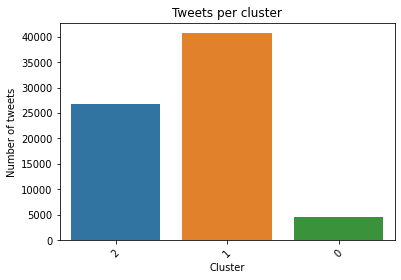

In [25]:
    sns.countplot(data=df, x = "kmeans_label_umap")
    plt.title(f"Tweets per cluster")
    plt.xticks(rotation=45)
    plt.ylabel("Number of tweets")
    plt.xlabel("Cluster")
    plt.show()

Insight: Reasonable clustering. 2 clearly large clusters, and 1 smaller cluster. 

#####Sentiment for each Cluster

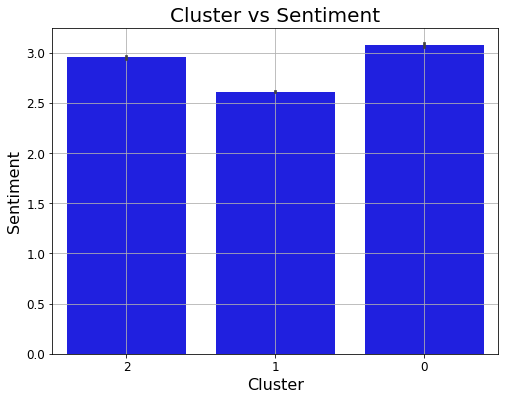

In [26]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'star', x = 'kmeans_label_umap', color = "blue")
plt.xlabel('Cluster', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Cluster vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

Insight: Cluster 0 has highest mean sentiment, and cluster 2 has lowest. Clusters 1 and 2 are very similar. The overall low sentiment across all 3 clusters could be because of the presence of "war" words (such as "fighting", "bomb", "crash", "lose", etc.) that could have dragged the overall sentiment down. 

In [28]:
df.head(2)

,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,...,in_reply_to_user_id,geo,entities,created_at_datetime,sentiment,star,text_clean,umap_tfidf_x,umap_tfidf_y,kmeans_label_umap
0,23990,2022-02-23T20:38:41.000Z,None,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",en,0.0,1.0,0.0,0.0,1.496585e+18,...,407020992.0,NaN,"{'mentions': [{'start': 0, 'end': 8, 'username': 'varbmos', 'id': '407020992'}, {'start': 9, 'end': 19, 'username': 'peterdaou', 'id': '18464266'}], 'annotations': [{'start': 26, 'end': 28, 'probability': 0.8232, 'type': 'Other', 'normalized_text': 'God'}, {'start': 42, 'end': 51, 'probability': 0.4109, 'type': 'Person', 'normalized_text': 'Russiagate'}, {'start': 212, 'end': 215, 'probability': 0.931, 'type': 'Place', 'normalized_text': 'Kiev'}]}",2022-02-23 20:38:41,1.585668,2.0,varbmos peterdaou oh my god this is so russiagate all over again one part of the dc ghost story kind of checks out and then youre insane to remember we were promised faked gas attacks and tanks rolling into kiev,-0.232718,0.178999,2
1,23989,2022-02-24T03:20:16.000Z,None,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",en,0.0,1.0,3.0,0.0,1.496686e+18,...,NaN,NaN,"{'urls': [{'start': 81, 'end': 104, 'url': 'https://t.co/66v0XT1QeW', 'expanded_url': 'https://webcam.guru.ua/city/Kiev/', 'display_url': 'webcam.guru.ua/city/Kiev/'}, {'start': 105, 'end': 128, 'url': 'https://t.co/VV6MqUTsjN', 'expanded_url': 'https://twitter.com/stormsellwx/status/1496686387541778432/video/1', 'display_url': 'pic.twitter.com/VV6MqUTsjN'}], 'annotations': [{'start': 15, 'end': 18, 'probability': 0.9841, 'type': 'Place', 'normalized_text': 'Kyiv'}, {'start': 21, 'end': 27, 'probability': 0.4673, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 63, 'end': 69, 'probability': 0.9769, 'type': 'Place', 'normalized_text': 'Ukraine'}]}",2022-02-24 03:20:16,4.232207,4.0,live view from kyiv ukraineghost townprayers for all of ukrainesource,-0.470258,0.038998,2


##### T-Test for Cluster vs Sentiment

In [48]:
w1 = "1"
w2 = ["2","0"]

for w2 in w2:
  X0 = df.sentiment[df.kmeans_label_umap==w1].dropna()
  X1 = df.sentiment[df.kmeans_label_umap==w2].dropna()
  mu0 = np.mean(X0)
  mu1 = np.mean(X1)
  (tstat, pval) =stats.ttest_ind(X0,X1, equal_var = True)

  print(f"Cluster\tMean Sentiment")
  print(f"{w1}\t{mu0:.2f}")
  print(f"{w2}\t{mu1:.2f}")
  print(f"Comparing Retweet Counts for {w1} vs {w2}: t-stat = {tstat:.3f} ({pval:.4f})\n")
  alpha = 0.01  #significance level
  if pval <=alpha:
    print(f"Significant at {alpha*100}% level. Average sentiment is not within statistical tolerance at 1%")
  else:
    print(f"Not significant at {alpha*100}% level. Mean retweet count of both groups within statistical tolerance of {alpha*100}% ")
  print("\n------------------------------------------\n")

Cluster	Mean Sentiment
1	2.62
2	2.96
Comparing Retweet Counts for 1 vs 2: t-stat = -51.254 (0.0000)

Significant at 1.0% level. Average sentiment is not within statistical tolerance at 1%

------------------------------------------

Cluster	Mean Sentiment
1	2.62
0	3.09
Comparing Retweet Counts for 1 vs 0: t-stat = -37.839 (0.0000)

Significant at 1.0% level. Average sentiment is not within statistical tolerance at 1%

------------------------------------------



In [40]:
tstat

-46.87313900681393

In [43]:
X0

3        1.983735
4        3.344243
5        2.957530
7        3.726612
12       3.663463
           ...   
71996    1.675389
71997    2.948112
71998    2.529476
71999    2.654192
72000    3.189356
Name: sentiment, Length: 40714, dtype: float64

#####Wordcloud for each cluster

In [ ]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)

        print(f"\n\tCluster {k} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")
stopwords.add("Ghostofkyiv")
stopwords.add("Kyiv")
stopwords.add("video")
stopwords.add("pilotfull")

kmeans_label_umap

	Cluster 0 has 6488 tweets


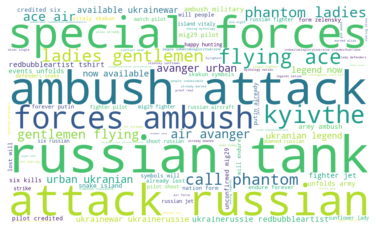


	Cluster 1 has 30031 tweets


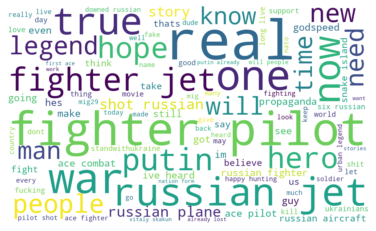


	Cluster 2 has 35481 tweets


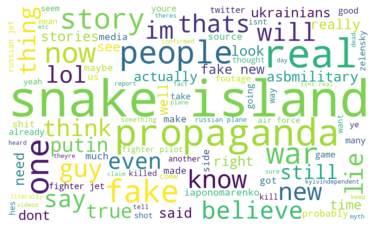

1

In [ ]:


cluster_label_column= 'kmeans_label_umap'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

Cluster 2 seems to be calling out the fake news, the fact that the footage of GOK was a video game recording, that it could be propaganda. Interestingly it also references snake island. 



1.   Cluster 2 (35K tweets) seems to be calling out the fake news, the fact that the footage of GOK was a video game recording, that it could be propaganda. Interestingly it also references snake island, which could indicate that those calling out the fakenews were referencing to Snake Island as well. This cluster had the lowest sentiment. Words such as "fake", "propganda", "story" feature prominently. The word "asbmilitary" turned up as well - this is a pro-russian account that was calling out this misinformation, while simultaneously spreading unverifiable information (misinformation?) about Russian forces. It is possible that this cluster emerged after the initial spread of misinformation (i.e. in the tail end of the time series graph)
2.   Cluster 1 (30K tweets) is all about praising the pilot. Words like "hero", "legend", "hope", feature prominently, indicating people's propensity to quickly pass judgements and express hope in a fictional character.
3. Cluster 0 seems to be a collection of tweets talking about the invasion in general. It doesn't seem like we can extract a coherent trend from this cluster, apart from a generic reference to the invasion. This was also the smallest cluster with just 6.4K tweets. 



In [ ]:
fname_db1 = "data/gok_all_22feb_14apr"  #database filenmae (without .db extension)

df_gok = DB.fetch(table_name='keyword_tweets', path=fname_db1)

In [ ]:
df_gok.shape

(78590, 14)

In [ ]:
fname_db2 = "data/300k_snakeisland_acad_22feb_14apr"  #database filenmae (without .db extension)

df_si = DB.fetch(table_name='keyword_tweets', path=fname_db2)

In [ ]:
df_gok.head(1)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2022-04-13T23:36:30.000Z,None,"this is wilder than any of the ""ghost of kiev"" stuff. if you had told someone on february 24 that almost two months into the war the Ukrainians were threatening to sink Russia's flagship in the black sea you would have sounded completely insane lol",en,12,4,89,0,1514387079790215174,349817494,1514386669335687169,349817494,nan,"{'annotations': [{'start': 8, 'end': 13, 'probability': 0.5983, 'type': 'Person', 'normalized_text': 'wilder'}, {'start': 169, 'end': 174, 'probability': 0.9889, 'type': 'Place', 'normalized_text': 'Russia'}]}"


#Kathy - First 1000 Tweets Analysis

In [ ]:
df_keyword_1000 = df.sort_values(by = ['created_at_datetime'], ascending = True).head(n=1000)

In [ ]:
df_keyword_1000.shape

(1000, 21)

######How much engagement did those first 1,000 tweets get? What was the retweet and like breakdown per post? In total?

In [ ]:
mean_like = df_keyword_1000['like_count'].mean()
print(f"Like Count Mean = {mean_like}")
mean_retweet = df_keyword_1000['retweet_count'].mean()
print(f"Retweet Count Mean = {mean_retweet}")

total_like = df_keyword_1000['like_count'].sum()
print(f"Like Count Total = {total_like}")
total_retweet = df_keyword_1000['retweet_count'].sum()
print(f"Retweet Count Total = {total_retweet}")


Like Count Mean = 720.305
Retweet Count Mean = 90.485
Like Count Total = 720305
Retweet Count Total = 90485


Time Series Plot (Rate of first 1,000 tweets)

#####How long did it take for the first 1,000 tweets to get posted about this topic?



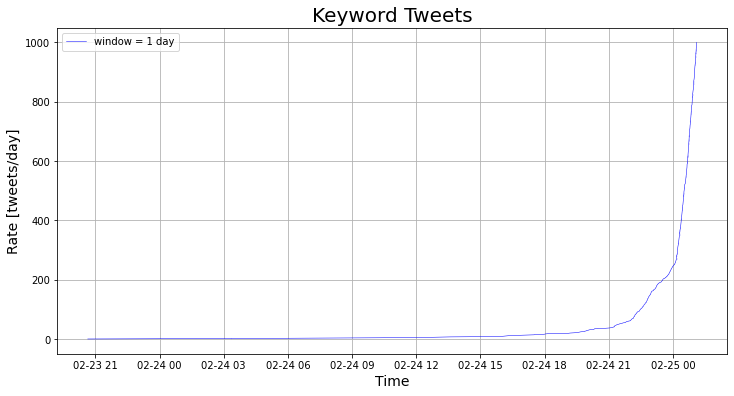

In [ ]:

format = "%Y-%m-%d %H:%M:%S"
df_keyword_1000 ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword_1000 .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword_1000 ['tweet_indicator'] = np.ones(len(df_keyword_1000 ))
df_keyword_1000 ['rate_1D'] = df_keyword_1000 .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']

fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword_1000 , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')

plt.grid()
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()



#####Word Cloud of First 1,000 Tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


There are 1000 tweets in the dataframe


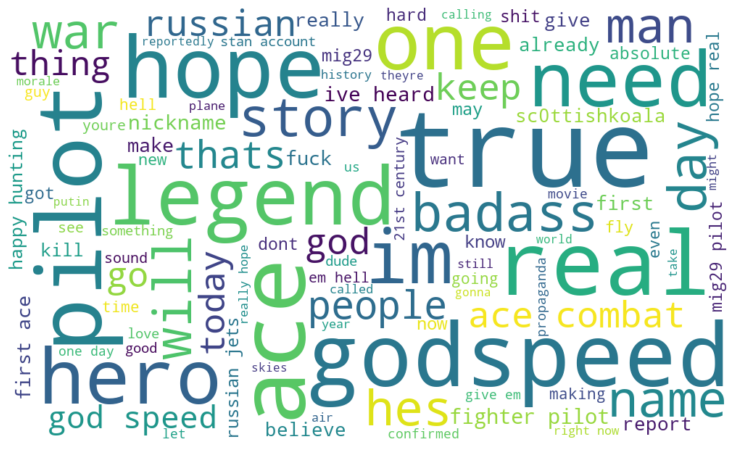

In [ ]:
stopwords = set(STOPWORDS)##

df_keyword_1000['text_clean'] = df_keyword_1000.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df_keyword_1000_clean = df_keyword_1000[df.text_clean.str.len() > 0]

n_1000 = len(df_keyword_1000_clean)
print(f"There are {n_1000} tweets in the dataframe")

stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")
stopwords.add("Ghostofkyiv")
stopwords.add("Kyiv")
stopwords.add("video")
stopwords.add("pilotfull")
stopwords.add("fucking") #censor

text=' '.join(df_keyword_1000.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#####Sentiment of first 1,000 tweets


Mean opinion of the tweets:3.133930188226675


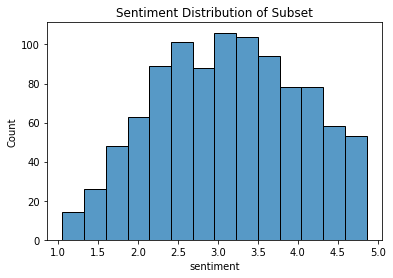

In [ ]:
mean_opinion_1000 = df_keyword_1000['sentiment'].mean()
print(f"Mean opinion of the tweets:{mean_opinion_1000}")

df_plot = df_keyword_1000
sns.histplot(data=df_plot, x = "sentiment")
plt.title(f"Sentiment Distribution of Subset")
plt.show()



#Divjot - Time Series Plot (rate of new tweets)

##### **Feburary 22 - March 1**

In [ ]:
start_date = '2022-02-22 00:00:00'
end_date = '2022-03-01 00:00:00'


df_1 = df_keyword[(df_keyword['created_at_datetime'] > start_date) & (df_keyword['created_at_datetime'] <= end_date)]
df_1.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,tweet_indicator,rate_1D,rate_7D
23990,2022-02-23T20:38:41.000Z,None,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",en,0,1,0,0,1496585327204470784,40311253,1496578659670499330,407020992,nan,"{'mentions': [{'start': 0, 'end': 8, 'username': 'varbmos', 'id': '407020992'}, {'start': 9, 'end': 19, 'username': 'peterdaou', 'id': '18464266'}], 'annotations': [{'start': 26, 'end': 28, 'probability': 0.8232, 'type': 'Other', 'normalized_text': 'God'}, {'start': 42, 'end': 51, 'probability': 0.4109, 'type': 'Person', 'normalized_text': 'Russiagate'}, {'start': 212, 'end': 215, 'probability': 0.931, 'type': 'Place', 'normalized_text': 'Kiev'}]}",2022-02-23 20:38:41,1.0,1.0,0.142857
23989,2022-02-24T03:20:16.000Z,None,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",en,0,1,3,0,1496686387541778432,2823778745,1496686387541778432,nan,nan,"{'urls': [{'start': 81, 'end': 104, 'url': 'https://t.co/66v0XT1QeW', 'expanded_url': 'https://webcam.guru.ua/city/Kiev/', 'display_url': 'webcam.guru.ua/city/Kiev/'}, {'start': 105, 'end': 128, 'url': 'https://t.co/VV6MqUTsjN', 'expanded_url': 'https://twitter.com/stormsellwx/status/1496686387541778432/video/1', 'display_url': 'pic.twitter.com/VV6MqUTsjN'}], 'annotations': [{'start': 15, 'end': 18, 'probability': 0.9841, 'type': 'Place', 'normalized_text': 'Kyiv'}, {'start': 21, 'end': 27, 'probability': 0.4673, 'type': 'Place', 'normalized_text': 'Ukraine'}, {'start': 63, 'end': 69, 'probability': 0.9769, 'type': 'Place', 'normalized_text': 'Ukraine'}]}",2022-02-24 03:20:16,1.0,2.0,0.285714


In [ ]:
df_1.tail(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,tweet_indicator,rate_1D,rate_7D
40735,2022-02-28T23:59:43.000Z,None,@jacksonhinklle Not even ghost of Kyiv could help Ukraine win.,en,0,1,11,0,1498447858215038976,599204880,1498447620431224832,1151913018936053760,nan,"{'annotations': [{'start': 34, 'end': 37, 'probability': 0.8232, 'type': 'Place', 'normalized_text': 'Kyiv'}, {'start': 50, 'end': 56, 'probability': 0.965, 'type': 'Place', 'normalized_text': 'Ukraine'}], 'mentions': [{'start': 0, 'end': 15, 'username': 'jacksonhinklle', 'id': '1151913018936053760'}]}",2022-02-28 23:59:43,1.0,5863.0,6686.571429
40734,2022-02-28T23:59:49.000Z,None,@FrankB716 @GramsciGordon @KFCBarstool There seems to be confusion in the comments about whether those are Russian or Ukrainian jets and where folks are saying they are Ukrainian there is confusion about whether or not the jets are the same class the ghost of Kyiv uses. Additionally there is no source for the vid. 🤷🏻‍♂️,en,0,2,1,0,1498447881455427586,1426019674765025286,1497370299653832705,479970093,nan,"{'annotations': [{'start': 260, 'end': 263, 'probability': 0.7814, 'type': 'Place', 'normalized_text': 'Kyiv'}], 'mentions': [{'start': 0, 'end': 10, 'username': 'FrankB716', 'id': '479970093'}, {'start': 11, 'end': 25, 'username': 'GramsciGordon', 'id': '1347659135077249024'}, {'start': 26, 'end': 38, 'username': 'KFCBarstool', 'id': '119758732'}]}",2022-02-28 23:59:49,1.0,5864.0,6686.714286


######Time Series Graph

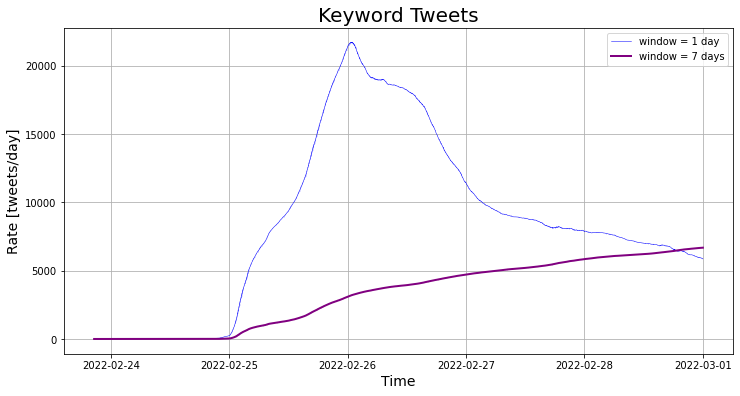

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_1 , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_1 , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

Insight: significant rise in tweet rate regarding the keywords starting on February 25th. Constant rise in 7 day window analysis. WIth the invasion gaining steam and a potential war rising, the keywords became very popular on twitter.

######Word Cloud

In [ ]:
stopwords = set(STOPWORDS)##
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Kyiv")
stopwords.add("Ghostofkiev")
stopwords.add("Ghostofkyiv")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")

In [ ]:
df_1['text_clean'] = df_1.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df_1 = df_1[df_1.text_clean.str.len() > 0]

n = len(df_1)
print(f"There are {n} tweets in the dataframe")
#df_1.sample(n=5)



There are 46807 tweets in the dataframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


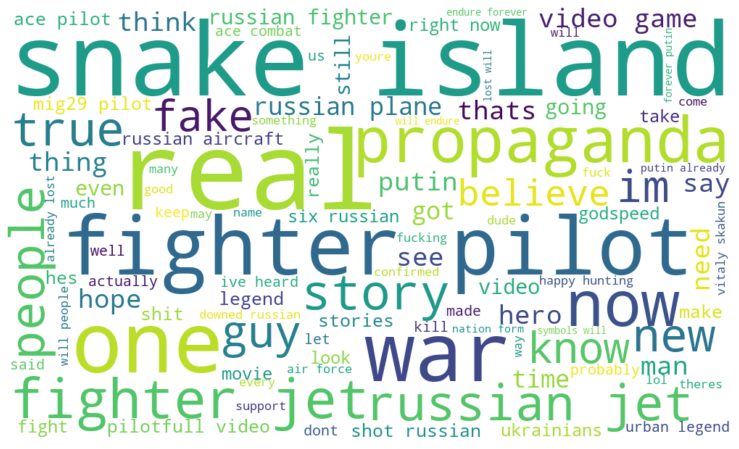

In [ ]:
text=' '.join(df_1.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insights: Lot of the keywords were focused on real v fake news, with key words such as propaganda especially more in use. Focus on key words such as snake island as well.

##### **March 1 - March 9**

In [ ]:
start_date2 = '2022-03-01 00:00:00'
end_date2 = '2022-03-09 00:00:00'


df_2 = df_keyword[(df_keyword['created_at_datetime'] > start_date2) & (df_keyword['created_at_datetime'] <= end_date2)]
df_2.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,tweet_indicator,rate_1D,rate_7D
14666,2022-03-01T00:00:02.000Z,None,"Me, accelerating fast in my car: *Ralph Wiggum voice* I'm the Ghost of Kiev",en,2,0,19,0,1498447937600380928,19004939,1498447937600380928,nan,nan,"{'annotations': [{'start': 34, 'end': 45, 'probability': 0.9443, 'type': 'Person', 'normalized_text': 'Ralph Wiggum'}, {'start': 71, 'end': 74, 'probability': 0.4526, 'type': 'Place', 'normalized_text': 'Kiev'}]}",2022-03-01 00:00:02,1.0,5865.0,6686.857143
40733,2022-03-01T00:00:10.000Z,None,"@bigjennyg @KyivIndependent I would suggest that this all started with them denying the Ghost of Kyiv, who was a man, so it's not Sexist.\nBut I recently found out that the Ghost was an inter-sectional black woman.\nSo like totally.\nBigots! https://t.co/pucVcIxYDw",en,0,0,1,0,1498447969116372996,948599302288326656,1498119030338695169,1304232091626815489,nan,"{'annotations': [{'start': 97, 'end': 100, 'probability': 0.3391, 'type': 'Place', 'normalized_text': 'Kyiv'}], 'urls': [{'start': 239, 'end': 262, 'url': 'https://t.co/pucVcIxYDw', 'expanded_url': 'https://twitter.com/AnonymousAtman/status/1498447969116372996/photo/1', 'display_url': 'pic.twitter.com/pucVcIxYDw'}], 'mentions': [{'start': 0, 'end': 10, 'username': 'bigjennyg', 'id': '1304232091626815489'}, {'start': 11, 'end': 27, 'username': 'KyivIndependent', 'id': '1462548977367359490'}]}",2022-03-01 00:00:10,1.0,5866.0,6687.000000


######Time Series Graph

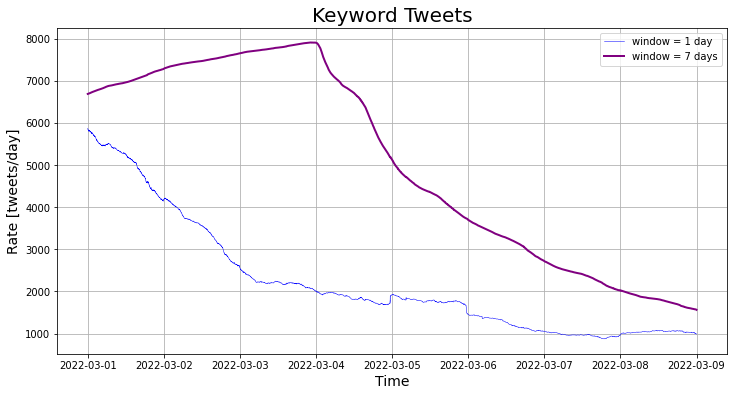

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_2 , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_2 , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

Insight: Significant significant decline. In 1 day and 7 day windows both. After the initial flow, decrease in tweets on the topic. A decline after the initial rapid increase, maybe due to less sensation effect.

In [ ]:
df_2['text_clean'] = df_2.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df_2 = df_2[df_2.text_clean.str.len() > 0]

n = len(df_2)
print(f"There are {n} tweets in the dataframe")
#df_2.sample(n=5)

There are 15137 tweets in the dataframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


######Word Cloud

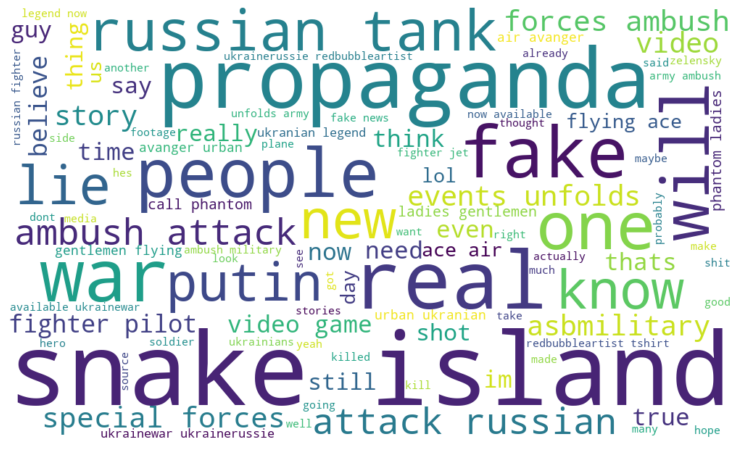

In [ ]:
text=' '.join(df_2.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insight: Word cloud focused heavily on snake island, and potentially Russian propaganda. Similar word cloud as beforehand

##### **March 9 - April 13**

In [ ]:
start_date3 = '2022-03-09 00:00:00'
end_date3 = '2022-04-13 00:00:00'


df_3 = df_keyword[(df_keyword['created_at_datetime'] > start_date3) & (df_keyword['created_at_datetime'] <= end_date3)]
df_3.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,created_at_datetime,tweet_indicator,rate_1D,rate_7D
8560,2022-03-09T00:01:14.000Z,None,Ghost of Kiev? https://t.co/28lmGyRGDH,en,0,1,0,0,1501347342326272003,1191692380216451078,1501347342326272003,nan,nan,"{'urls': [{'start': 15, 'end': 38, 'url': 'https://t.co/28lmGyRGDH', 'expanded_url': 'https://twitter.com/KyivIndependent/status/1500936843675721728', 'display_url': 'twitter.com/KyivIndependen…'}], 'annotations': [{'start': 0, 'end': 12, 'probability': 0.3299, 'type': 'Organization', 'normalized_text': 'Ghost of Kiev'}]}",2022-03-09 00:01:14,1.0,988.0,1564.428571
33178,2022-03-09T00:01:23.000Z,None,"@31k0ubaj One side is lying really openly. Probably both, but days after the Ghost of Kyiv was discovered to be video game footage, the official Ukraine account did a whole tribute to him. There's an effort to confuse things.",en,0,1,2,0,1501347380418990085,1136265425027772417,1501343416969568261,1206478527530487808,nan,"{'annotations': [{'start': 78, 'end': 90, 'probability': 0.533, 'type': 'Other', 'normalized_text': 'Ghost of Kyiv'}, {'start': 146, 'end': 152, 'probability': 0.9161, 'type': 'Place', 'normalized_text': 'Ukraine'}]}",2022-03-09 00:01:23,1.0,989.0,1564.285714


######Time Series Graph

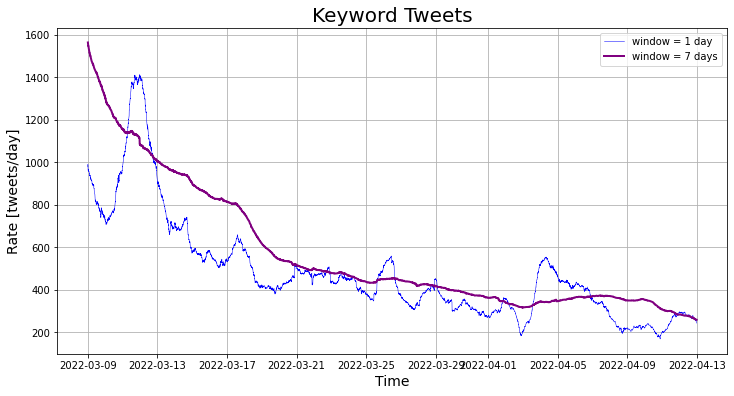

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_3 , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_3 , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

Insight: More steady decline in the tweet rates regarding the keywords. As time progressed, the rate got into a more stable decline as opposed to previous date ranges.

In [ ]:
df_3['text_clean'] = df_3.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df_3 = df_3[df_3.text_clean.str.len() > 0]

n = len(df_3)
print(f"There are {n} tweets in the dataframe")
#df_2.sample(n=5)

There are 16362 tweets in the dataframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


######Word Cloud

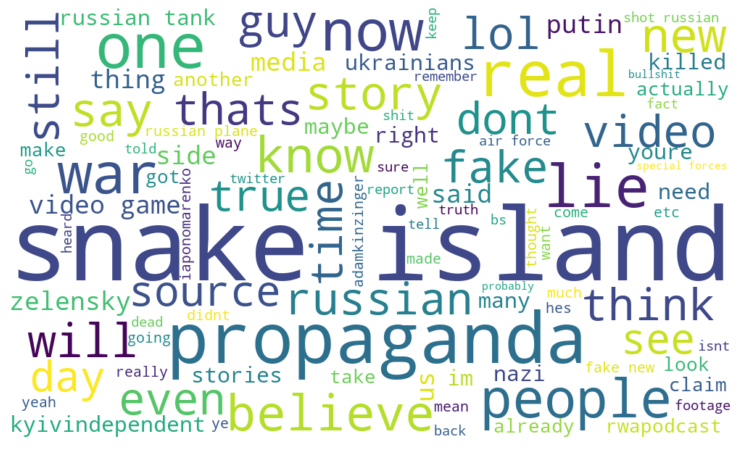

In [ ]:
text=' '.join(df_3.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insight: Similar word cloud, but looks more positive relative to the real v fake debates in the previous regions

# Nithin - Prof idea: Which users that talked about both GOK and SI got retweeted most?

######Load Tweets (GOK and SI)

In [ ]:
fname_db1 = "data/gok_all_22feb_14apr"  #database filenmae (without .db extension)

df_gok = DB.fetch(table_name='keyword_tweets', path=fname_db1)

In [ ]:
df_gok.shape

(78590, 14)

In [ ]:
fname_db2 = "data/300k_snakeisland_acad_22feb_14apr"  #database filenmae (without .db extension)

df_si = DB.fetch(table_name='keyword_tweets', path=fname_db2)

In [ ]:
df_si.shape

(48684, 14)

Insight: Dataset sizes- GOK is 78k tweets, SI is 48k tweets

######Sort by retweet count and select top 50

In [ ]:
df_gok_top=df_gok.sort_values("retweet_count", ascending = False).head(50)
df_si_top = df_si.sort_values("retweet_count", ascending = False).head(50)


######Isolate Author IDs

In [ ]:
df_gok_top_id = df_gok_top["author_id"]
df_si_top_id = df_si_top["author_id"]

In [ ]:
df_gok_top_id.sample(2)

69539               16906660
70061    1266719171863351297
Name: author_id, dtype: object

In [ ]:
df_si_top_id.sample(2)

46245              878284831
45966    1258153337498865665
Name: author_id, dtype: object

######Compare Dataframes and isolate unique values

In [ ]:
df_common = pd.merge(df_gok_top_id,df_si_top_id, on=['author_id'],how='inner')
df_common.drop_duplicates()

,author_id
0,732521058507620356
1,3223426134
2,878284831
5,930552552302792705
6,859409582426251269
8,2979242392
9,1222773302441148416
10,825518870421180416
11,358545917


**Insights:**


LOTs of interesting insights. See the excel sheet, under the Worksheet "Concrete Steps - GOK"


#Convert to HTML (last step)

In [ ]:
!jupyter nbconvert --to HTML FinalProject.ipynb

[NbConvertApp] Converting notebook FinalProject.ipynb to HTML
[NbConvertApp] Writing 2116626 bytes to FinalProject.html
